# Appendix 2: Redefining the stellar edge and resampling

*Author: Hannu Parviainen*<br>
*Last modified: 20.8.2020*

The spherical models extend quite a bit over what we'd consider the 'edge' of the star (Wittkowski et al. A&A 413, 2004; Espinoza & Jordan, MNRAS 450, 2015). Thus, the edge needs to be (re)defined, and the z and $\mu$ need to be recomputed using the new edge distance. Also, while the used $\mu$ sampling works to capture the detail close to the stellar limb, it is not optimal for LD model fitting, as it gives way too much weight to the edge.

LDTk redefines the limb automatically at the ``LDPSet`` initialisation, and this can be done manually using the ``LDPSet.set_limb_z`` and ``LDPSet.set_limb_mu`` methods. The $\mu$ sampling can be changed using the ``LDPSet.resample_linear_z``, ``LDPSet.resample_linear_mu``, and ``LDPSet.resample`` methods.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.interpolate import interp1d
from os.path import join
import seaborn as sb
sb.set_style('white')

from ldtk.core import SIS, ldtk_root

In [3]:
sis = SIS(join(ldtk_root,'cache_lowres','Z-0.0','lte05800-5.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits'))
mu_o, z_o, ip_o = sis.mu, sis.z, sis.intensity_profile()

## Redefining the stellar edge

In [4]:
def plot_ld(mu, z, ip, mu_range=(-0.01,1.01), ylim=(-0.01,1.01)):
    fig,ax = subplots(1,2,figsize=(13,4), sharey=True)
    ax[0].plot(mu, ip)
    ax[0].scatter(mu, ip, marker='o')
    ax[1].plot(z, ip)
    ax[1].scatter(z, ip, marker='o')
    setp(ax, xlim=(0,1.01), ylim=ylim)
    setp(ax[0], xlim=mu_range, xlabel='$\mu$')
    setp(ax[1], xlim=sqrt(1- clip(array(mu_range)**2,-5,1))[::-1], xlabel='z')
    fig.tight_layout()
    return fig,ax

Let's first plot the stellar intensity profile as a function of $\mu$ and $z$, and take a closer look at what happens near the edge.

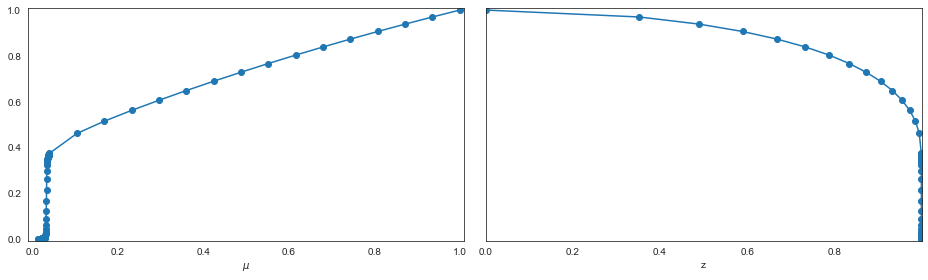

In [5]:
plot_ld(mu_o, z_o, ip_o);

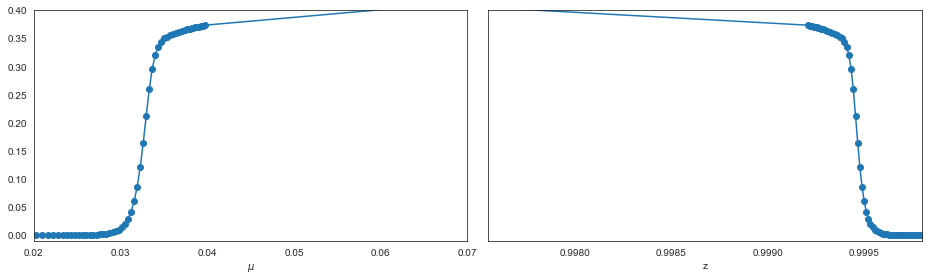

In [6]:
plot_ld(mu_o, z_o, ip_o, mu_range=(0.02,0.07), ylim=(-0.01,0.4));

It's clear that the sampling continues over the stellar edge. We need to fix this by redefining the edge and recalculating the $z$ and $\mu$ values. I choose the same approach as chosen in Espinoza & Jordan (MNRAS 450, 2015): we define the edge to correspond to the $z$ value where the derivative of the intensity profile is maximum.

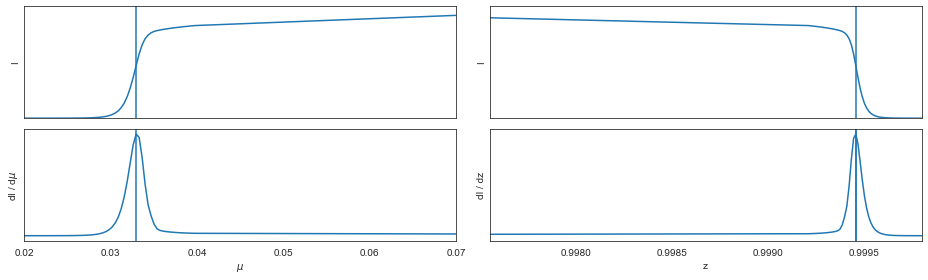

In [7]:
ipm = argmax(abs(diff(sis.intensity_profile())/diff(sis.z)))
fig, axs = subplots(2, 2, figsize=(13,4), sharex='col')
axs[0,0].plot(sis.mu, sis.intensity_profile())
axs[1,0].plot(sis.mu[1:], abs(diff(sis.intensity_profile())/diff(sis.mu)))
[ax.axvline(sis.mu[ipm+1]) for ax in axs[:,0]]
axs[0,1].plot(sis.z, sis.intensity_profile())
axs[1,1].plot(sis.z[1:], abs(diff(sis.intensity_profile())/diff(sis.z)))
axs[1,1].axvline(sis.z[ipm+1])
[ax.axvline(sis.z[ipm+1]) for ax in axs[:,1]]

setp(axs[0,0], xlim=(0.02,0.07), ylabel='I', yticks=[], ylim=(0,0.45))
setp(axs[0,1], xlim=sqrt(1-array((0.02,0.07))**2)[::-1], ylabel='I', yticks=[], ylim=(0,0.45))
setp(axs[1,0], xlabel='$\mu$', xlim=(0.02,0.07), ylabel='dI / d$\mu$', yticks=[])
setp(axs[1,1], xlabel='z', xlim=sqrt(1-array((0.02,0.07))**2)[::-1], ylabel='dI / dz', yticks=[])
#setp(ax[1], xlim=(0.9,1.001))
fig.tight_layout()

In [8]:
i = argmax(abs(diff(ip_o)/diff(z_o)))
z_new  = z_o[i:]/z_o[i]
mu_new = sqrt(1-z_new**2)
ip_new = ip_o[i:]

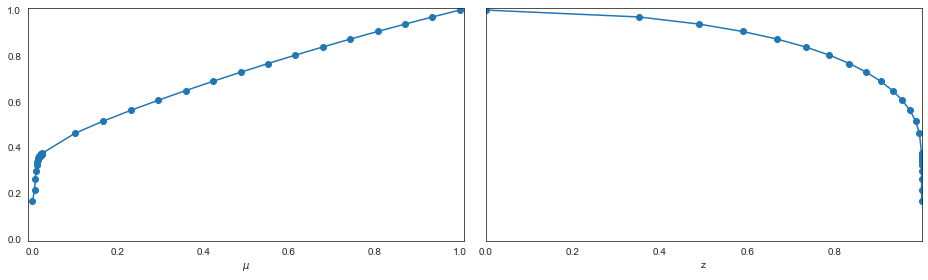

In [9]:
plot_ld(mu_new, z_new, ip_new);

## Resampling 

In [10]:
z_rs = linspace(0,1,100)
mu_rs = sqrt(1-z_rs**2)
ip_rs = interp1d(z_new[::-1], ip_new[::-1], kind='linear', assume_sorted=True)(z_rs)

In [11]:
ip_f1 = poly1d(polyfit(mu_new, ip_new, 2))(mu_rs)
ip_f2 = poly1d(polyfit(mu_rs,  ip_rs,  2))(mu_rs)

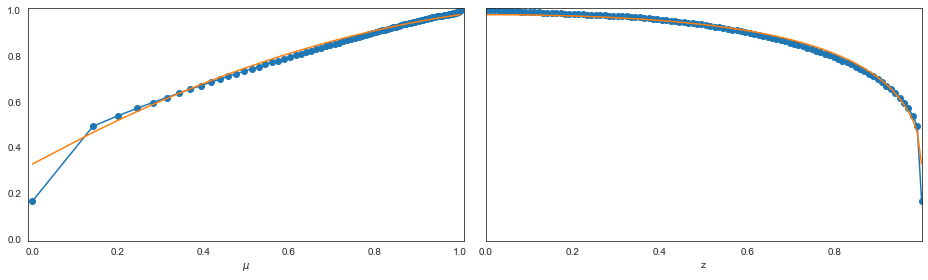

In [12]:
fig,ax = plot_ld(mu_rs, z_rs, ip_rs);
ax[0].plot(mu_rs, ip_f1)
ax[1].plot(z_rs,  ip_f1);

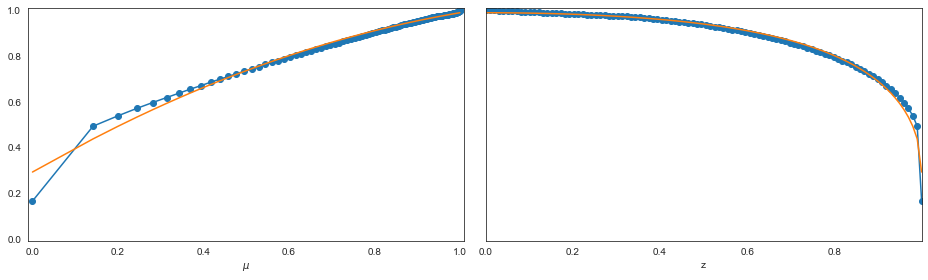

In [13]:
fig,ax = plot_ld(mu_rs, z_rs, ip_rs);
ax[0].plot(mu_rs, ip_f2)
ax[1].plot(z_rs, ip_f2);

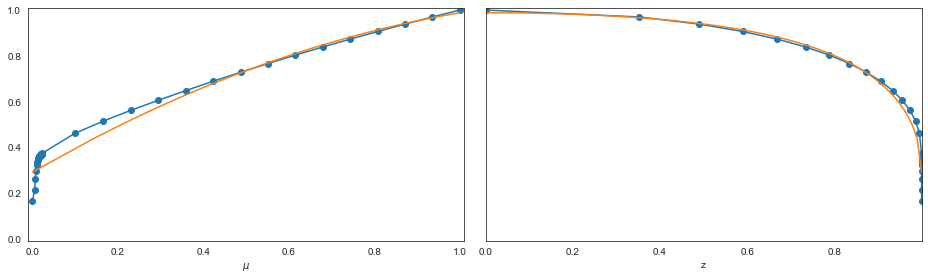

In [14]:
fig,ax = plot_ld(mu_new, z_new, ip_new);
ax[0].plot(mu_rs, ip_f2)
ax[1].plot(z_rs, ip_f2);

---
<center> &copy; 2020 <a href="mailto:hannu@piac.es">Hannu Parviainen</a></center>